In [75]:
import tensorsketch as ts
import tqdm
import numpy as np
from Bio import SeqIO
import glob
import matplotlib.pyplot as plt
from numba import njit, prange, cuda, objmode
import pandas as pd

import edlib

In [92]:
kmer_size = 8               #@param {type:"slider",min:1,max:32,step:1}
tuple_size = 3              #@param {type:"slider",min:1,max:10,step:1}
sketch_dim = 20             #@param {type:"slider",min:10,max:300,step:10}
run_cuda_models = False     #@param {type:"boolean"}
alphabet_size = 4

window = 10000
stride = 5000
normalize = True
sample = ord('m')

common = dict(A=alphabet_size,D=sketch_dim)
tss = ts.TSS(t=tuple_size, S=stride, W=window, **common)

tsm = ts.TSM(t=tuple_size, S=stride, W=window, normalize=normalize,sample=sample,**common)

In [106]:

# Map from sequence characters to internal integer representation.
_char_map: dict[str, int] = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
_char_comp: dict[str, str] = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}


def reverse_complement(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i in range(len(s)):
        char_list[i] = _char_map[_char_comp[s[-i-1]]]
    return char_list

# Given the char_map above, returns an array of length 256 mapping bytes to
# internal integers. -1 signals unknown bytes.

def seq2array(s) -> np.ndarray:
    char_list = np.full(len(s), -1, dtype=np.int8)
    for i,k in enumerate(s):
        char_list[i] = _char_map[k]
    return char_list

data = "/Users/amirjoudaki/Downloads/S_Baltica_new"
files = glob.glob(data + '/*')
print(files)

all_seqs = []
for file in files:
    records = SeqIO.to_dict(SeqIO.parse(file, "fasta"))
    for name,record in records.items():
        seq = dict(file = file, id=record.id, name=record.name, description=record.description)
        seq['seq'] = record.seq
        seq['array'] = seq2array(record.seq)
        seq['rarray'] = seq2array(record.seq)
        all_seqs.append(seq)

all_seqs

['/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS195.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS185.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS625.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_BA175.new.new.all.fna', '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS155.new.new.all.fna']


[{'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS223.new.new.all.fna',
  'id': 'CP001252.1',
  'name': 'CP001252.1',
  'description': 'CP001252.1 Shewanella baltica OS223 chromosome, complete genome 0',
  'seq': Seq('TTTTTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTG...GCG'),
  'array': array([3, 3, 3, ..., 2, 1, 2], dtype=int8),
  'rarray': array([3, 3, 3, ..., 2, 1, 2], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS675.new.new.all.fna',
  'id': 'CP002383.1',
  'name': 'CP002383.1',
  'description': 'CP002383.1 Shewanella baltica OS678, complete genome 0',
  'seq': Seq('TTTAAGGATAGCGATCCTTGAGATCTCGCTATAGAATACACCTCTTTTTTGATG...TAA'),
  'array': array([3, 3, 3, ..., 3, 0, 0], dtype=int8),
  'rarray': array([3, 3, 3, ..., 3, 0, 0], dtype=int8)},
 {'file': '/Users/amirjoudaki/Downloads/S_Baltica_new/S_Baltica_OS117.new.new.all.fna',
  'id': 'C_017579.1',
  'name': 'C_017579.1',
  'description': 'C_017579.1 Shewanella baltica OS117, co

In [110]:
%%time
for seq in tqdm.tqdm(all_seqs,total=len(all_seqs)):
    sketch, inds = tsm.sketch(seq['array'])
    # rsketch, rinds = tsm.sketch(seq['rarray'])
    seq['sketch'] = dict(name='tsm',
                         array=sketch,
                         inds=inds,
                         # rarray=rsketch,
                         # rinds=rinds
                         )

100%|██████████| 8/8 [02:09<00:00, 16.21s/it]

CPU times: user 1min 2s, sys: 9.69 s, total: 1min 11s
Wall time: 2min 9s


In [154]:
s1, s2 = 0, 5
seq1, seq2 = all_seqs[s1]['seq'],all_seqs[s2]['seq']
sk1, sk2 = all_seqs[s1]['sketch']['array'], all_seqs[s2]['sketch']['array']
sk1 = sk1.transpose() / np.sqrt(np.nansum(sk1**2,axis=1))
sk2 = sk2.transpose() / np.sqrt(np.nansum(sk2**2,axis=1))
prod = np.matmul(sk1.transpose(),sk2)
dists = np.array([(i,j,1-prod[i,j]) for i in range(prod.shape[0]) for j in range(prod.shape[1])])
idx = np.argsort(dists[:,2])
dists = dists[idx,:]

In [156]:
num_samples = 200
uniform_dists = np.random.random(num_samples)**4 / 2
uniform_indices = np.searchsorted(dists[:,2],uniform_dists)
uniform_indices = list(range(num_samples))
df = pd.DataFrame(columns=['s1','s2','i1','i2','j1','j2','d','ed','ed_norm','ed2','ed_norm2'])
for index in tqdm.tqdm(uniform_indices):
    i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]
    idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
    query, target = seq1[idx1-window:idx1],seq2[idx2-window:idx2]
    result = edlib.align(query,target,task='path')
    if not result['cigar']:
        continue
    nice = edlib.getNiceAlignment(result, query, target)
    first = nice['matched_aligned'].find('|'*15)
    query_aligned = nice['query_aligned'][:first]
    target_aligned = nice['target_aligned'][:first]
    d1, d2 = query_aligned.count('-'), target_aligned.count('-')
    L = window - max(d1,d2)
    result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
    ed, ed_norm = result['editDistance'], result['editDistance']/window
    ed2, ed_norm2 = result2['editDistance'],result2['editDistance']/L

    # print("\n".join([str(v) for k,v in nice.items()]))
    df.loc[len(df),:] = (s1,s2,idx1-window,idx1,idx2-window,idx2,d,ed,ed_norm,ed2, ed_norm2)
df

100%|██████████| 200/200 [01:35<00:00,  2.10it/s]


,s1,s2,i1,i2,j1,j2,d,ed,ed_norm,ed2,ed_norm2
0,0,5,711214,721214,146295,156295,0.0,0,0.0,0,0.0
1,0,5,707424,717424,142505,152505,0.0,11,0.0011,11,0.0011
2,0,5,701212,711212,136293,146293,0.000001,15,0.0015,15,0.0015
3,0,5,4903543,4913543,4043341,4053341,0.000005,241,0.0241,241,0.0241
4,0,5,4401215,4411215,4943005,4953005,0.000006,154,0.0154,154,0.0154
...,...,...,...,...,...,...,...,...,...,...,...
194,0,5,4242341,4252341,4795465,4805465,0.000153,624,0.0624,407,0.04127
195,0,5,3958744,3968744,2116033,2126033,0.000153,1570,0.157,689,0.072116
196,0,5,4411255,4421255,4953044,4963044,0.000154,1290,0.129,1290,0.129013
197,0,5,4517708,4527708,905062,915062,0.000155,5160,0.516,4469,0.514743


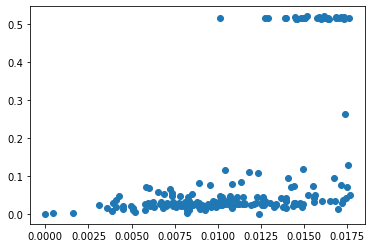

In [159]:
plt.scatter([np.arccos(1-v) for v in df.d.values], df.ed_norm2)

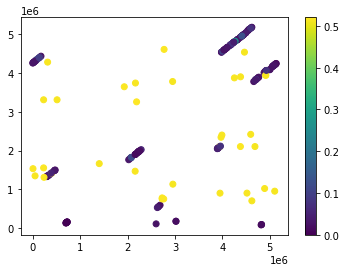

In [160]:
plt.scatter(df.i1, df.j1, c=df.ed_norm2)
plt.colorbar()

In [150]:
index = 20
i, j, d = int(dists[index,0]),int(dists[index,1]), dists[index,2]

d = np.linalg.norm(sk1[:,i]- sk2[:,j])
idx1,idx2 = all_seqs[s1]['sketch']['inds'][i], all_seqs[s2]['sketch']['inds'][j]
S1, S2 = seq1[idx1-window:idx1],seq2[idx2-window:idx2]
query, target = S1,S2
result = edlib.align(query,target,task='path')
nice = edlib.getNiceAlignment(result, query, target)
first = nice['matched_aligned'].find('|'*10)
query_aligned = nice['query_aligned'][:first]
target_aligned = nice['target_aligned'][:first]
d1, d2 = query_aligned.count('-'), target_aligned.count('-')
L = window - max(d1,d2)
result2 = edlib.align(target[d1:d1+L],query[d2:d2+L])
ed, ed_norm = result2['editDistance'],result2['editDistance']/L
print(f'{i}, {j}, {idx1}, {idx2} {d:.5f}, {ed_norm:.3f}')


539, 1039, 2695293, 5198619 0.00869, 0.030


In [146]:
# I = int(3e6)
# L = int(10e3)
# query = seq1[I:I+L]
# target = seq2
result = edlib.align(query, target, task='path')
nice = edlib.getNiceAlignment(result, query, target)
print('locations = ', result['locations'])
print('match score = ',nice['matched_aligned'].count('|')/len(query))
nice['matched_aligned']

locations =  [(0, 9999)]
match score =  0.956


'----|----|--|-|||-------|----|---|---|-|--------|--|----||---||------|----|--||-|-----|--|---|-----|-|--|--|-|-|-----|---|--|--|---|-|--|----|--||-|---------|-|--|-||-|-----|||-----|--|-||--||---|--||------|----|-|-|-|---------------|----|--|------|---|------|-----||-|---------------|--||---|-|||-----||-|-|--|-|--|--|--||---|---------|----|---|-----|---|||----------|||--|--|----------|-|-|----|--|-|---------------||-------------|--|-|-----|------|-|-|-|--------|--------|||-------|-|--|--------||---|--|--------|----||---|----||-||-------|--|----|--|-||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [73]:
[query.count(c) for c in 'ACGT'],[target.count(c) for c in 'ACGT']

([5520, 4995, 4426, 5059], [5536, 4986, 4417, 5061])

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

N = len(all_seqs)

for i in range(N):
    for j in range(i,N):
        sk1 = all_seqs[i]['sketch']['array']
        sk2 = all_seqs[j]['sketch']['array']
        sk1 = sk1.transpose() / np.sqrt(np.sum(sk1**2,axis=1))
        sk2 = sk2.transpose() / np.sqrt(np.sum(sk2**2,axis=1))
        prod = np.matmul(sk1.transpose(),sk2)
        angle = np.arccos(prod) / np.pi

        plt.matshow(angle)
        plt.colorbar()
        plt.title(f'seq {i} vs. seq {j}')
        plt.show()